# Making Space Invaders Fun and Accessible with Brain-Computer Interfacing

## Executive Summary

Technological advancements such as gesture control, voice recognition, virtual and augmented reality are redefining gaming, advancing an already booming and competitive industry. The project detailed in this report is a redesigned version of Space Invaders, with the ship controlled using gestures, specifically left and right eye movements. Its development is motivated by the financial success of similarly advanced games such as Pokemon Go and without doubt, the original Space Invaders which was a technological wonder for its time. 

{numref}`flow` is a workflow diagram which illustrates the process undergone in the development of the product and how the Physics and Data Science disciplines worked as one unit. After performing a plethora of experiments, it was found that having the electrodes at least 3cm apart, performing fast eye movements and placing left and right markers for the user, generated a clean, noticeable signal. Additionally, collecting data from all team members gave enough variation in the data to ensure our classifier is robust and general. 

Determining the event detection statistic that best distinguishes between regions of events and non-events involved evaluating the relationship between window size and contrast between the detection metric of said regions. The best performing detection method was found to be zero-crossings; the number of times the signal crosses origin per second, with an optimal detection window length of 0.35s. 

Similarly, determining the optimal classifier involved evaluating the relationship between window size and accuracy of the classifier. The most accurate and latent classifier was found to be the ‘Max-Min-Range’ classification rule with 96% accuracy and requiring no extension on the detection window. This classifier smooths the signal using a savitzky-golay filter, then determines if the first turning point is a minimum or maximum. The time taken to execute each classifier (except for KNN) is negligible and thus did not contribute to our choice of classifier.

Re-designing Space Invaders to be controlled using left and right eye movements is not solely useful as an entertaining game with potential commercial success. It is a tool that can act as a learning interface to teach individuals how gesture control performs (as the technology is inevitably integrated into our everyday lives) by using a familiar, nostalgic game such as space invaders. Additional applications include inclusive gaming for those with muscular impairments and building a foundation model for future projects to extend.


### Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import wavfile
import matplotlib.pyplot as plt
import time
from scipy.fft import fft, fftfreq, fftshift
from scipy import signal
from copy import deepcopy
from catch22 import catch22_all
import catch22
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from numba import njit
from weighted_levenshtein import lev
import struct
import warnings
import serial
warnings.filterwarnings('ignore')

# Update this to point to the report folder
PATH = "../"
# To run all computation, change to True. Otherwise, precomputed files will be loaded instead.
compute_all = True
# If running, ensure the following line is commented out. It disables plots for knitting to html purposes. 
# %matplotlib agg

# Set seed for reproducibility
np.random.seed(420) 
# Path to outputs folder
OUT_PATH = PATH + "report_outputs/"
# Path to data
IN_PATH = PATH + "data/"
# Path to other file dependencies
DEP_PATH = PATH + "requirements/other_files/"




## Motivation & Background

Over the past two decades, profound advancements in technology such as facial recognition, gesture control, virtual assistants and other instances of machine learning have gradually been integrated into everyday life. With virtual reality worth over \$21 billion alone {cite}`VR`, the gaming industry is evidently undergoing a similar transformation. The financial success of games such as Pokemon Go, which used augmented reality to re-develop the themes and goals of its franchise, is reason enough to design and implement a game that is similarly controlled by one of these technological advancements. 

This project involves using gesture control, one of these technological advancements, to re-develop Space Invaders, the iconic 80’s game which grossed an equivalent of $13 billion {cite}`SpaceInvaders`, using left and right eye movements as the spaceship's controls. These movements are represented by signals generated by the Backyard Brains Spikerbox {cite}`BYB`.

Our target market is anyone interested in leading technologies and gaming, akin to Pokemon Go’s and the original Space Invaders audience. A short survey was conducted and out of 33 people, 85% said they would be interested in this version of Space Invaders. This demonstrates potential commercial success with a remastered launch.

The fundamental aim of this project is to accurately and efficiently detect eye movements, and distinguish between left and right signals. This becomes an arduous task if solely Physics or Data Science is used to implement this project. The workflow diagram in {numref}`flow` visually explains the role of each discipline, and how the success of the final product depends on the integration of these sciences. In particular, the Physics discipline is responsible for the experimental design and collection of data, to generate a clean, noticeable signal that is representative of a larger population. The Data Science discipline is responsible for implementing code that reads this data, searches for the occurrence of a movement and classifies the specific gesture. Additionally, the integrated knowledge and skills of the two disciplines led to designing and implementing a method that evaluates the performance of the detection and classification code in terms of accuracy and efficiency. 

Thus, using the skills and knowledge of Physics and Data Science, a well-tested gesture controlled version of Space invaders can be developed.


```{figure} ../report_outputs/flow.png
---
scale: 30%
name: flow
---
Workflow diagram illustrating the process undergone by both Physics and Data Science disciplines in the re-development of the game Space Invaders.
```
<!-- reference by {numref}`flow` -->

## Methods
### Experimentation & Data Collection

In reference to {numref}`flow`, the first step in the re-development of Space Invaders requires experimenting with the Spikerbox to collect data which is representative of the Space Invaders application. The aim of experimentation is to determine how left and right eye movements change as physical aspects of the experimental design vary.

#### Physical Experiments Performed & Findings

The following sections detail the plethora of experiments performed and specifically what each test was exploring.



**General eye movements**

The first experiment is to determine if distinguishing between left and right eye movements is possible. Two electrodes were placed above the eyebrow of a team members eye and they were instructed to look forward. Then, the team member moved their eyes left or right, then immediately back to the middle.  (insert figure reference to signal graph) illustrates that while the signal shape of left and right eye movements appears the same, the polarity of the signals is inverted.

**Varying speed of eye movements**

The team member is now instructed to vary the speed at which they look left or right. It was found that when eye movements were too slow, the signal associated with looking from the middle to the left and looking from the left back to the middle became separated. However, with fast eye-movements, these two separate signals became one, yielding the same output as before.

**Varying distance of eye movements**

Now, the team member is asked to perform normal left-middle and right-middle eye movements, but with each iteration they must look further away from the middle position. This involved placing objects equally apart, acting as targets to look at. It was found that if the eye moved slightly away from the middle, a signal was barely detectable. This distance was not quantified, as it is dependent on the individual performing the experiment. As the eyes moved further away from the centre, the amplitude of the signal grew accordingly. 

**Electrode placement**

We now experiment with the configuration of the electrode placements. It was found that placing the electrode vertically across the eye as opposed to horizontally no longer generates a distinguishable signal for left and right eye movements. Instead, the best movement associated with this placement is up and down.

Additionally, it was found that altering the distance between the electrodes to be closer than around 3cm to each other failed to generate a noticeable, distinguishable signal with left and right eye movements.

**Changing individual & changing boxes**

As experimental equipment was swapped, such as the Spikerbox itself, electrodes and connecting wires, or a new team member collecting the data, the signal generated was subject to change. Such changes included variation in noise, signal amplitude and in worst cases a completely different signal signature.

**Determining how the signal changes with natural movements**

The user is now asked to sit still and blink naturally, then move their face (smile, raise their eyebrows, shake their head, scrunch their nose, etc.). The blinks were small, detectable peaks in the signal, whereas movement of the muscles in their face cause a dramatic increase in noise and sometimes amplitude.

(methods:experiment:findings)=
#### Implications of Findings 

From our above findings, we adapted the final data collection method to include the following points: 
- Data was collected by placing the electrodes at least 3cm apart in a horizontal configuration above the eyebrow. 
- The user was instructed to move their eyes quickly. However, these movements are separated by minimum time intervals to prevent merging the signals. 
- Throughout data collection, markers were placed on the left and right of the user to act as a target, ensuring they moved their eyes far enough to generate a strong signal. 
- Data was collected from more than one individual to ensure the dataset is representative of a larger group. 
- To overcome the issue due to noise, it would be appropriate during pre-processing to use a noise filter. 
- To overcome the issue due to changing signal amplitude, pre-processing of the signal should additionally involve normalisation or calibration.

#### Sample Collection of Data
Using the points outlined in {ref}`methods:experiment:findings`, we prepared 8 wave files (.wav) to the following specifications:
- 50 seconds in length
- First 5 seconds is a calibration period - no movements performed
- A sequence of left and right movements are performed for the remaining 45 seconds
- Each file is accompanied with a labels textfile (.txt) containing the timestamps and labels of every event in the wavefile. '1' corresponds to a left eye movement, and '2' corresponds to a right eye movement.
- Each .wav file has a range of [0, 1024], but are centred to [-512, 512] within the `load_data` function defined below.

Two of the eight files were randomly selected as the test set, and the rest were assigned to the training set. 

In [2]:
def load_data(path, fnames, scale_factor = 1, shift_factor = -512, fix_alessandro=False, offsets=None):
    waves = {}
    labels = {}
    for file in fnames:
        # Load in wave file
        samprate, wav_array = wavfile.read(path+file+".wav")
        wav_array = wav_array*scale_factor
        wav_array += shift_factor
        # Fix the bug in alessandro's code
        if fix_alessandro:
            fixed_wav = []
            step = 999
            offset = offsets[file]
            for j, i in enumerate(range(offset, len(wav_array)-step, step)):
                if j == 0:
                    fixed_wav.append(np.flip(wav_array[0:i+step]))
                fixed_wav.append(np.flip(wav_array[i:i+step]))
            waves[file] = np.concatenate(fixed_wav)
        else:
            waves[file] = wav_array
        # Load in label file
        labels_dat = pd.read_csv(path+file+".txt", sep=",\t", skiprows=1)
        labels_dat.columns = ["label", "time"]
        labels_dat.label = ["L" if label == 1 else "R" for label in labels_dat.label]
        labels[file] = labels_dat
    print(f"Successfully loaded {len(waves)} wavefiles:")
    print("\n".join(sorted(waves.keys())))
    return waves, labels

fnames = ["data1", "data2", "data3", "data4", "data5", "data6", "data7", "data8"]

# Offsets to fix the error in alessandro's code
offsets = {"data1":0,
           "data2":0,
           "data3":0,
           "data4":0,
           "data5":-5,
           "data6":0,
           "data7":-1,
           "data8":0}

# Randomly select two files for the test set, remainder as training
test_files = np.random.choice(fnames, 2, replace=False)
training_files = list(set(fnames) - set(test_files))

# Training Data
waves, labels = load_data(
    IN_PATH, training_files, scale_factor = 1, shift_factor = -512, fix_alessandro=True, offsets=offsets)

# Test Data
test_waves, test_labels = load_data(
    IN_PATH, test_files, scale_factor = 1, shift_factor = -512, fix_alessandro=True, offsets=offsets)

# Define Calibration Window and Sample Rate: 10,000 Hz
calibration_window_sec = 5
samprate = 10_000


Successfully loaded 6 wavefiles:
data1
data2
data3
data4
data6
data8
Successfully loaded 2 wavefiles:
data5
data7


Next, we convert the singular timestamps in the labels dataframe to the time interval of the entire event. There was a minor data quality issue with some of the timestamps which caused some files to have slightly shifted timestamps. To fix this, we went through and manually defined the interval for each file (the time to add before and after the timestamp to get the desired interval). We did this once to encompass the entire wave signal, and another time to only cover the first hump of the signal.


In [3]:
# First hump
time_buffers_hump = {
    "data1":(-0.3, 0.55),
    "data2":(-0.3, 0.55),
    "data3":(-0.3, 0.55),
    "data4":(-0.5, 0.75),
    "data5":(-0.5, 0.75),
    "data6":(-0.5, 0.75),
    "data7":(-0.5, 0.75),
    "data8":(-0.5, 0.75)
}

# Whole wave
time_buffers_whole = {
    "data1":(-0.2, 1.15),
    "data2":(-0.2, 1.15),
    "data3":(-0.2, 1.15),
    "data4":(-0.4, 1.35),
    "data5":(-0.4, 1.35),
    "data6":(-0.4, 1.35),
    "data7":(-0.4, 1.35),
    "data8":(-0.4, 1.35),
}


#### Streaming Algorithm Design

First, we must design the basic structure of our streaming algorithm. The algorithm will consist of two parts, the first is event detection, and the second is classification. As the streaming data comes in, we will only keep a window of fixed length in memory, effectively behaving as a sliding window at the front of the stream. This window updates in discrete intervals of some *buffer length*, and we will deem this window the *classification window*. 

Within that classification window, we will fix another smaller window that slides along with the classification window. This subset of the classification window is what we will test an event criterion on, and is hence called the *detection window*. 

Each time the window is updated by the stream, the event criterion is tested on the detection window. To minimise false positives, that criterion will need to pass a set number of times, dictated by the `consecutive_event_triggers` parameter.

Once the event criterion has passed `consecutive_event_triggers` times, we pass the classification window to the classifier algorithm and block the classifier from detecting another event. When the event criterion has failed `consecutive_nonevent_reset` times, we prime the streaming algorithm to predict events again. This is to stop the algorithm from detecting the same event twice.



In [4]:
# Function that reads in the kth <inputBufferSize> sized segment of the array
# Simulates streaming condition on recorded wavefiles.
def read_arduinbro(wav_array, inputBufferSize, k):
    if inputBufferSize*(k+1) < len(wav_array):
        data = wav_array[(inputBufferSize*(k)):(inputBufferSize*(k+1))]
    else:
        data = wav_array[(inputBufferSize*(k))::]
    return np.flip(data)


In [5]:
def streaming_classifier(
        wav_array,                             # Either the array from file (or ser if live = True)
        samprate,
        classifier,
        input_buffer_size_sec = 0.1,           # Buffer size in seconds
        store_events = False,                  # Whether to return the classification window array for
                                                   # debugging purposes
        store_times = False,                   # Store time taken for each classification
        live = False,
        FIFO_filename = None,
        create_FIFO_msg = None,

        classifier_params = {},
        classification_window_size_sec = 1.5,  # Total detection window [s]

        calibration_window_size_sec = 5,       # The length of the calibration period to define the threshold
        calibration_statistic_function = None, # Function that calculates the calibration statistic

        detection_window_size_sec = 0.5,
        detection_window_offset_sec = 0.5,
        event_test_statistic_function = None,  # Function that calculates the test statistic
        event_threshold_factor = 0.5,          # The scale factor of the calibration stat that will become
                                                   # the threshold
        flip_threshold = False,                # Threshold is a lower bound if true, upper bound if false
        consecutive_event_triggers = 3,        # How many threshold triggers need to occur in a row for an 
                                                   # event to be called
        consecutive_nonevent_reset = 10         # How many threshold failures need to occur in a row for the
                                                   # classifier to be primed for a new event
        ):

    # Connect to fifo
    if FIFO_filename is not None:
        fifo = os.open(FIFO_filename, os.O_WRONLY)
    
    if store_events:
        predictions_storage = []
    if store_times:
        classification_times = []
    predictions = ""
    predictions_timestamps = []

    # Initialise variables
    N_loops_over_window = classification_window_size_sec//input_buffer_size_sec
    input_buffer_size = int(round(input_buffer_size_sec * samprate))
    detection_window_offset = int(round(detection_window_offset_sec * samprate))
    detection_window_size = int(round(detection_window_size_sec * samprate))
    
    # Initialise Calibration
    calibrate = True
    N_loops_calibration = calibration_window_size_sec//input_buffer_size_sec

    # Initialise Event History
    num_event_history = max(consecutive_event_triggers,
                            consecutive_nonevent_reset) + 1 
    event_history = np.array([False]*num_event_history)

    # Determine length of stream
    if live:
        N_loops = np.inf
    else:
        total_time = len(wav_array)/samprate
        N_loops = (total_time*samprate)//input_buffer_size

    # Prime the classifier for new event
    primed = True
    
    ### Start stream ###
    k = 0
    while k < N_loops:
        if live:
            data = read_arduino(wav_array,input_buffer_size)
            data_temp = process_data(data)
        else:
            data_temp = read_arduinbro(wav_array, input_buffer_size, k)
        if k < N_loops_over_window:
            if k == 0:
                data_cal = data_temp
                data_window = data_temp
            else:
                data_window = np.append(data_temp, data_window)
                if calibrate:
                    data_cal = np.append(data_temp, data_cal)
            k+=1
            continue
        else:
            data_window = np.roll(data_window,len(data_temp))
            data_window[0:len(data_temp)] = data_temp
            if calibrate:
                data_cal = np.append(data_temp,data_cal)
                if (k > N_loops_calibration):
                    cal_stat = calibration_statistic_function(data_cal)
                    event_threshold = cal_stat*event_threshold_factor
                    calibrate = False
                k+=1
                continue
        # Event Detection
        # Take detection window from classification window
        
        interval = data_window[detection_window_offset:(detection_window_offset + detection_window_size)] 
        test_stat = event_test_statistic_function(interval) # Calculate test stat 
                
        # Test threshold
        if flip_threshold:
            is_event = (test_stat < event_threshold) 
        else:
            is_event = (test_stat > event_threshold)
        
        # Record History
        event_history[1::] = event_history[0:-1]
        event_history[0] = is_event
        
        # if event, pass window to classifier
        if np.all(event_history[0:consecutive_event_triggers]) and primed:
            start = time.time_ns()
            prediction = classifier(data_window, samprate, **classifier_params)
            end = time.time_ns()
            if store_times:
                classification_times.append(end - start)
            if store_events:
                predictions_storage.append(data_window)
                        
            # Record prediction and time interval of event
            predictions += prediction
            end_time = round(k*input_buffer_size_sec, 2)
            start_time = round(end_time - classification_window_size_sec, 2)
            predictions_timestamps.append((start_time, end_time))

            # Pipe it up
            if FIFO_filename is not None:
                msg = create_FIFO_msg(prediction)
                os.write(fifo, msg)
            
            # Unprime
            primed = False
        
        # Check if condition for priming has been met
        if np.all(~event_history[0:consecutive_nonevent_reset]):
            primed = True

        k += 1
    
    if FIFO_filename is not None:
        os.close(fifo)
    
    if store_events and store_times:
        return predictions, predictions_timestamps, predictions_storage, classification_times
    elif store_events:
        return predictions, predictions_timestamps, predictions_storage
    elif store_times:
        return predictions, predictions_timestamps, classification_times
    else:
        return predictions, predictions_timestamps
                  

### Optimisation

We optimise the streaming algorithm in two dependent stages in accordance to {numref}`flow`. The first stage is to optimise event detection by choosing the best test statistic and threshold to apply over the detection window. The test statistic will be the statistic that maximises the contrast between event and non-event regions, and the threshold will be the threshold that maximises the $F_1$-score on the training set. 

When our algorithm is effective at distinguishing events from non-events, we will use the optimised event detection method to optimise our classifiers on the training set. Once all classifiers are optimised, we will choose the classifier with the best accuracy on the test set based on a levenshtein distance weighted to reflect what is most desirable for its Space Invaders use.

Finally, once all classifiers are optimised on the training set, we test their accuracy on the test set to determine the best classifier. 

#### Event Detection 
<!-- 
(write lil nicer) Hypothesis from physics perspective: plotting contrast against window length we expect a peak which is the optimal point, taking the appearance of normalisation curve. Thus, two pieces of information (best metric and optimal window length) can be extracted. -->

##### Test Statistic

The first component to optimising event detection is to choose the best test statistic to be applied over the detection window. To do this, we first define five possible candidates for the test statistic. These candidates were chosen because they were deemed likely to be effective in distinguishing events from non-events. Specific justifications are commented above each of the five functions below.

In [6]:
# Define Test Stat Functions

# due to their sine wave-like shape, events have a larger range than non-events
def ts_range(x): 
    return np.max(x) - np.min(x)

# the range but using the middle half of the distribution to reduce influence from outliers
def ts_IQR(x): 
    return np.quantile(x, 0.75) - np.quantile(x, 0.25)

# events have high peaks due to their shape compared to non-events
def ts_abs_max(x): 
    return np.max(np.abs(x))

# non-events cross the zero line (x-axis) often due to noise, 
# while events have long periods over/under the zero line
def ts_zero_crossings(x):
    return np.sum(x[0:-1]*x[1::] <= 0)


tfn_candidates = {"Range": ts_range,
                  "IQR": ts_IQR,
                  "SD": np.std,
                  "Absolute Max": ts_abs_max,
                  "Zero Crossings": ts_zero_crossings}



##### Evaluation Metric (Contrast)

To determine the best test statistic from the candidates, we first calculate a series of test statistics using a sliding window over each training file. Next, we define an evaluation metric called *contrast*. Essentially, contrast is the absolute value of the Welch's t-test statistic between the set of statistics for event regions, and the set of statistics for non-event regions for a given candidate statistic. It is defined by the following formula:
```{math}
:label: contrast
\textit{contrast}(E, E^*) = \frac{|\bar{E} - \bar{E^*}|}{\sqrt{\frac{\sigma_E^2}{N_E} + \frac{\sigma_{E^*}^2}{N_{E^*}}}}
```
<!-- reference it by {eq}`contrast` -->
where $E$ is the set of test statistics calculated over event regions, $E^*$ is the non-event region test statistics, and $\bar{k}$, $\sigma_k$ and $N_k$ are the mean, standard deviation and number of elements in set $k$ respectively.

This will yield the contrast for each candidate statistic when using a specific sliding window length.


In [7]:
def contrast(events, non_events): 
    pooled_sd = np.sqrt(np.var(events)/len(events) + np.var(non_events)/len(non_events))
    return np.abs(np.mean(events, axis=1) - np.mean(non_events, axis=1))/pooled_sd

Next, we perform a gridsearch varying the window length from 0 to 2 seconds and calculating the contrast of each candidate statistic for each window length. The results are shown in {numref}`contrast`. The best test statistic can be seen to be 'zero crossings' with an optimal detection window length of 0.45 seconds. Zero crossings is defined in {eq}`zeros`.

```{math}
:label: zeros
\text{Z}(\mathbf{x}) = \frac{\sum_{i=1}^{n-1} \text{min}\left(\text{sign}(x_i\times x_{i+1}), 0\right)}{n}
```
<!-- reference it by {eq}`zeros` -->
Where $\mathbf{x}$ is the detection window with $n$ samples.

In [8]:
def get_event_regions(wav_array, samprate, labels_dat, time_buffer):
    before_buffer = time_buffer[0]
    after_buffer = time_buffer[1]
    
    time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate

    left_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "L"]:
        left_events_bool = (((time_seq > time - before_buffer) & 
                             (time_seq < time+after_buffer)) | left_events_bool)

    right_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "R"]:
        right_events_bool = (((time_seq > time - before_buffer) & 
                              (time_seq < time + after_buffer)) | right_events_bool)

    event_bool = left_events_bool | right_events_bool
    return event_bool


def get_test_stats(wav_array, window_size, step, test_stat_fns):
    test_stats = np.zeros((len(test_stat_fns), len(wav_array)))
    all_windows = np.lib.stride_tricks.sliding_window_view(wav_array, window_shape = window_size)
    all_windows = all_windows[::step, :]
    for i, fn in enumerate(test_stat_fns):
        testicles = np.apply_along_axis(fn, -1, all_windows)
        for j, teste in enumerate(testicles):
            if j == len(testicles)-1:
                test_stats[i, (j*step)::] = teste
            else:
                test_stats[i, (j*step):((j+1)*step)]  = teste
    return test_stats


def get_contrast(wav_array, samprate, labels_dat, window_size, step, test_stat_fns, contrast_fn, time_buffer):
    test_stats = get_test_stats(wav_array, window_size, step, test_stat_fns)
    events_bool = get_event_regions(wav_array, samprate, labels_dat, time_buffer)
    event_test_stats = test_stats[:, events_bool]           
    non_event_test_stats = test_stats[:, ~events_bool]
    contrast_stat = contrast_fn(event_test_stats, non_event_test_stats)
    return contrast_stat

    
def contrast_all_files(output_filename, window_size, test_stat_fns, samprate, 
                       waves, labels, contrast_fn, step=0.1, time_buffers=time_buffers_whole):   
    step = int(step*samprate)
    for i, key in enumerate(waves.keys()):
        wav_array = waves[key]
        labels_dat = labels[key]
        
        cont = get_contrast(wav_array, samprate, labels_dat,
                         window_size, step, test_stat_fns,
                         contrast_fn, time_buffers[key])
        with open(output_filename, "a") as file:
            file.write(",".join([str(window_size), key]) + "," + ','.join(np.round(cont, 4).astype(str)) + "\n")

output_filename_event_det_opt = OUT_PATH + "event_detection_optimisation.csv"

if compute_all:
    granularity = 100
    open(output_filename_event_det_opt, 'w').close()    # Clears the file so that the code can be run again.
    for i, x in enumerate(np.linspace(100, 10000, granularity)):
        x = int(x)
        if i%10 == 0:
            print(f"{i} of {granularity}")
        contrast_all_files(
            output_filename_event_det_opt, 
            window_size = x, 
            test_stat_fns = tfn_candidates.values(),
            samprate = samprate,
            waves = waves,
            labels = labels,
            step = 0.1,
            contrast_fn = contrast,
            time_buffers = time_buffers_whole
        )
            

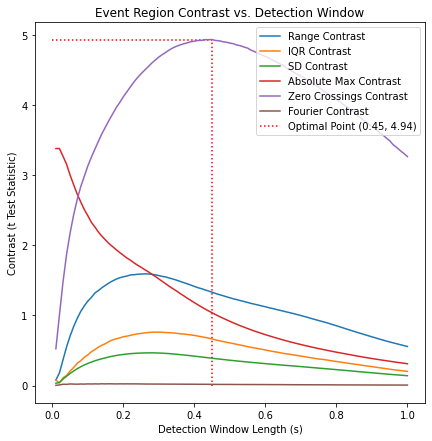

In [9]:
contrasts = pd.read_csv(output_filename_event_det_opt, header=None)
contrasts.columns = ["window_size", "file"] + list(tfn_candidates.keys())
contrasts_total = contrasts.groupby("window_size").mean()

plt.figure(figsize=(7, 7))
for stat in tfn_candidates.keys():
    plt.plot(contrasts_total.index/samprate,
             np.abs(contrasts_total[stat]),
             label = f"{stat} Contrast", alpha = 1)

plt.title("Event Region Contrast vs. Detection Window")
plt.xlabel("Detection Window Length (s)")
plt.ylabel("Contrast (t Test Statistic)")
opt_det_window = contrasts_total.index[np.argmax(np.abs(contrasts_total["Zero Crossings"]))]/samprate
opt_det_window_val = np.max(np.abs(contrasts_total["Zero Crossings"]))
plt.vlines(opt_det_window, 0, opt_det_window_val,"r", ":", 
           label=f"Optimal Point ({round(opt_det_window, 2)}, {round(opt_det_window_val, 2)})")
plt.hlines(opt_det_window_val, 0, opt_det_window,"r", ":")
plt.legend(loc="upper right")
plt.savefig(OUT_PATH+"contrast.png")

```{figure} ../report_outputs/contrast.png
---
scale: 75%
name: contrast
---
Contrast of each test statistic as a function of window size. The contrast is calculated using {eq}`contrast`. We can see that zero crossings produces the maximum contrast at a window length of 0.45 seconds.
```
<!-- reference by {numref}`contrast` -->

##### Threshold Optimisation

Now that we have determined the best test statistic and its optimal detection window, we use these values to determine the optimal threshold for event detection. To incorporate the findings in {ref}`methods:experiment:findings`, we make the threshold dependent on the calibration window. This is to control for the fact that some signals are more noisy than others. Hence, instead of searching for a raw threshold, we search for a factor which the zero crossings of the calibration window will be multiplied by to obtain the threshold. The formula for the threshold can be seen in {eq}`thresh`.

```{math}
:label: thresh
t = f\times\text{Z}(\mathbf{C})
```
<!-- reference it by {eq}`thresh` -->
Where $t$ is the threshold, $f$ is the threshold factor, $\mathbf{C}$ is calibration window and $\text{Z}$ is the normalised zero crossings as defined in {eq}`zeros`.

To do find the optimal threshold factor $f$, we perform yet another gridsearch to maximise $F_1$-score, defined in {eq}`f1`. We have used the F1-score to determine the performance of the event detection, as it weighs false positives and false negatives equally. For our application, a false positive would result in the spaceship moving without a players consent, and a false negative would result in a missed movement. Both of these scenarios are equally undesirable.

```{math}
:label: f1
F_1 = \frac{\text{TP}}{\text{TP}-\frac{1}{2}(\text{FP} + \text{FN})}
```
<!-- reference it by {eq}`f1` -->

The results are displayed below in {numref}`threshold`. We can see that a threshold factor of 0.33 results in the highest $F_1$-score of 0.995 over the training set.

In [10]:
output_filename_thresh_opt = OUT_PATH + "threshold_optimisation.csv"

if compute_all:
    open(output_filename_thresh_opt, "w").close() # Clear file
    for st_scale in np.linspace(0.01, 1, 100):
        fps, fns, tps, i = 0, 0, 0, 0
        for key in waves.keys():
            predictions, predictions_timestamps = streaming_classifier(
                waves[key],
                samprate,
                lambda x,y: "R" if np.random.rand()<0.5 else "L",
                input_buffer_size_sec = 0.05,
                classification_window_size_sec = opt_det_window,
                detection_window_size_sec = opt_det_window,
                detection_window_offset_sec = 0,
                calibration_window_size_sec = calibration_window_sec,
                calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
                event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
                event_threshold_factor = st_scale, 
                flip_threshold = True, 
                consecutive_event_triggers = 3, 
                consecutive_nonevent_reset = 10 
            )
            before_buffer = time_buffers_hump[key][0]
            after_buffer = time_buffers_hump[key][1]
            actual_times = [(time-before_buffer, time+after_buffer) for time in labels[key].time]
            actual_leftovers = deepcopy(actual_times)
            pred_leftovers = deepcopy(predictions_timestamps)
            tps += len(actual_times)
            for act_times in actual_times:
                if act_times[1] < calibration_window_sec:
                    actual_leftovers.remove(act_times)
                    continue
                for pred_times in predictions_timestamps:
                    if (act_times[0] < pred_times[1] and act_times[1] > pred_times[0] and
                        pred_times in pred_leftovers and act_times in actual_leftovers):
                        actual_leftovers.remove(act_times)
                        pred_leftovers.remove(pred_times)
            tps -= len(actual_leftovers)
            fns += len(actual_leftovers)
            fps += len(pred_leftovers)
            i += 1
        fscore = tps/(tps+0.5*(fns+fps))
        if (st_scale*100)%10 == 0:
            print(st_scale, fscore)
        with open(output_filename_thresh_opt, "a") as file:
            file.write(f"{st_scale},{fscore}\n")


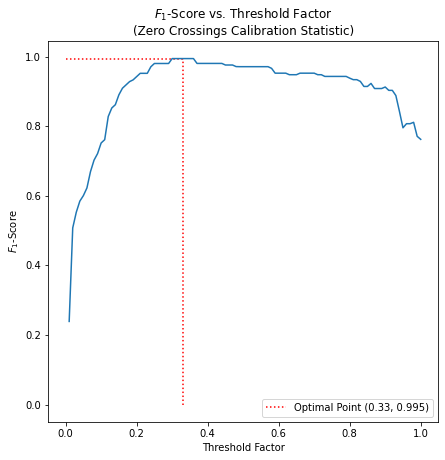

In [21]:
thresholds = pd.read_csv(output_filename_thresh_opt, header=None)
thresholds.columns = ["threshold_factor", "f_score"] 

thresh_factors = thresholds.threshold_factor
f_score_list = thresholds.f_score

plt.figure(figsize=(7, 7))
plt.plot(thresh_factors, f_score_list)
plt.title("$F_1$-Score vs. Threshold Factor\n(Zero Crossings Calibration Statistic)")
opt_thresh = np.mean(thresh_factors[f_score_list == np.max(f_score_list)])
opt_fscore = np.max(f_score_list)
plt.vlines(opt_thresh, 0, opt_fscore, "r", ":", 
           label=f"Optimal Point ({round(opt_thresh, 2)}, {round(opt_fscore, 3)})")
plt.hlines(opt_fscore, 0, opt_thresh, "r", ":")
plt.xlabel("Threshold Factor")
plt.ylabel("$F_1$-Score")
plt.legend(loc = "lower right")
plt.savefig(OUT_PATH+"threshold.png")

```{figure} ../report_outputs/threshold.png
---
scale: 75%
name: threshold
---
Plot of the $F_1$-score for different threshold factors on the training set. The threshold is obtained by {eq]`thresh`. We find the highest $F_1$-score occurs when the threshold factor is 0.33.
```
<!-- reference by {numref}`threshold` -->

#### Classification TO DO

<!-- for physics aspect just mention:
- again, what we predict the evaluation graph should look like
- we used a signal to filter the noise for one-three prong (mention its a physics thing to do when explaining classifier) -->


##### Classifiers

In [12]:
# Prepare Classifier Candidates

# catch22 kNN classifier (using stepwise selected features)
step_csv = DEP_PATH+"catch22_step_selected_features.csv"
catch22_step_training_data = pd.read_csv(step_csv)
X_train = catch22_step_training_data.iloc[:,0:-1]
y_labels = catch22_step_training_data.iloc[:,-1]   
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_labels)

# "Zeros" classifier
# returns a list of sub-arrays, grouped by the same consecutive value
# (in this case they are groups of consecutive 1s or -1s) 

@njit # numba decorator that performs just-in-time (jit) compilation
def consecutive(data, stepsize=0):                              
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

# looks for the first sequence where the sign doesn't change for a period of time,
# checks whether the average height is higher or lower than a threshold then classifies
@njit 
def zeroes_classifier(arr, samprate, downsample_rate=10, ave_height = 10, consec_seconds = 0.2):
    arr_ds = arr[0::downsample_rate]
    arr_sign = np.sign(arr_ds)            
    i = 0
    split_arrays = consecutive(arr_sign)  
    for sub_arr in split_arrays:
        if len(sub_arr) > consec_seconds * samprate / downsample_rate:  # RHS converts seconds to number of samples
            # if there were 'consec_seconds' seconds of no zero-crossings,
            # check if the average height is bigger than 'ave_height'
            if np.mean(arr_ds[i:(i + len(sub_arr) - 1)]) > ave_height:          
                return 'R'
            elif np.mean(arr_ds[i:(i + len(sub_arr) - 1)]) < -1 * ave_height:
                return 'L'
        i += len(sub_arr)
    return '_'   

# calculates the 5 features selected from catch22, find the 5 nearest neighbours 
# calculated using Euclidean distance, then selects the majority classification
def catch22_knn_classifier(arr, samprate, downsample_rate=10):
    arr_ds = arr[0::downsample_rate]
    arr_list = arr_ds.tolist()
    feature_one = catch22.DN_HistogramMode_5(arr_list)
    feature_two = catch22.SB_BinaryStats_mean_longstretch1(arr_list)
    feature_three = catch22.FC_LocalSimple_mean1_tauresrat(arr_list)
    feature_four = catch22.DN_OutlierInclude_p_001_mdrmd(arr_list)
    feature_five = catch22.SP_Summaries_welch_rect_area_5_1(arr_list)
    test_features = [[feature_one, feature_two, feature_three, feature_four, feature_five]]
    return neigh.predict(test_features)[0]                    

# wave is smoothed using Savitzky-Golay Filter, then decides whether the event is
# a left or right depending on whether the first turning point is a max or min
def one_pronged_smoothing_classifier(arr, samprate, downsample_rate=10, window_size_seconds=0.3, max_loops=10):
    arr_ds = arr[0::downsample_rate]
    fs = samprate/downsample_rate
    dt = 1/fs
    t = np.arange(0, (len(arr_ds)*dt), dt)

    # Smooth wave
    window_length = int(window_size_seconds*samprate/downsample_rate + 1)
    filtered_arr = signal.savgol_filter(arr_ds, window_length, 1)

    # Indices of positive maxima
    max_locs = np.array(signal.argrelextrema(filtered_arr, np.greater)[0])
    max_vals = filtered_arr[max_locs]
    max_locs = max_locs[max_vals > 0]
    
    # Indices of negative minima
    min_locs = np.array(signal.argrelextrema(filtered_arr, np.less)[0])
    min_vals = filtered_arr[min_locs]
    min_locs = min_locs[min_vals < 0]
    
    max_min_locs = np.append(max_locs, min_locs)    # Appended indices
    max_min_values = filtered_arr[max_min_locs]     # Values of above indices    
    abs_max_min_values = np.abs(max_min_values)     # Absolute value of those values

    # A vector with a length equal to the number of minimums: all '-1' to say minimum
    numMin = [-1]*len(min_locs)    
    numMax = [1]*len(max_locs)     # Same for max, but with '1'
    isMin = np.append(numMax, numMin)
    val_and_idx = np.vstack([abs_max_min_values, max_min_locs, isMin])
    # Sort the magnitudes of the extrema in descending order (-1 indicates descending)
    val_and_idx_sorted = val_and_idx[ :, (-1*val_and_idx[0]).argsort()]

    if val_and_idx_sorted.shape == (3, 0):
        if val_and_idx_sorted[2] == -1:
            return 'L'
        elif val_and_idx_sorted[2] == 1:
            return 'R'
        else:
            return "_"
    else:
        if val_and_idx_sorted[2, 0] == -1:
            return 'L'
        elif val_and_idx_sorted[2, 0] == 1:
            return 'R'
        else:
            return "_"

# wave is smoothed using Savitzky-Golay Filter, then decides whether the event is
# a left or right depending on the order of the maximum and minimum turning points
def two_pronged_smoothing_classifier(arr, samprate, downsample_rate=10, 
                                       window_size_seconds=0.3, max_loops=10):
    arr_ds = arr[0::downsample_rate]
    fs = samprate/downsample_rate
    dt = 1/fs
    t = np.arange(0, (len(arr_ds)*dt), dt)

    # Smooth wave
    window_length = int(window_size_seconds*samprate/downsample_rate + 1)
    filtered_arr = signal.savgol_filter(arr_ds, window_length, 1)

    # Indices of positive maxima
    max_locs = np.array(signal.argrelextrema(filtered_arr, np.greater)[0])
    max_vals = filtered_arr[max_locs]
    max_locs = max_locs[max_vals > 0]
    
    # Indices of negative minima
    min_locs = np.array(signal.argrelextrema(filtered_arr, np.less)[0])
    min_vals = filtered_arr[min_locs]
    min_locs = min_locs[min_vals < 0]
    
    max_min_locs = np.append(max_locs, min_locs)    # Appended indices
    max_min_values = filtered_arr[max_min_locs]     # Values of above indices    
    abs_max_min_values = np.abs(max_min_values)     # Absolute value of those values

    # A vector with a length equal to the number of minimums: all '-1' to say minimum
    numMin = [-1]*len(min_locs)    
    numMax = [1]*len(max_locs)     # Same for max, but with '1'
    isMin = np.append(numMax, numMin)
    val_and_idx = np.vstack([abs_max_min_values, max_min_locs, isMin])
    # Sort the magnitudes of the extrema in descending order (-1 indicates descending)
    val_and_idx_sorted = val_and_idx[ :, (-1*val_and_idx[0]).argsort()]
    
    # We will continue looping until we have an appropriate classification. 
    # This relies on having the extrema INTERCHANGE between max and min (no two min right next to eachother)
    loops = 0
    classificationFound = False
    while not classificationFound and loops < max_loops:
        
        top_2 = val_and_idx_sorted[:, 0:2]             # Take the top two magnitudes
        top_2_sorted = top_2[ :, top_2[1].argsort()]   # Sort according to the indices of those values
        if top_2_sorted.shape != (3, 2):               # Break if we run out of turning points
            return "_"
        
        # If two min or two max occur one after the other, 
        # we know we have an inappropriate result so we delete one of those doubled min/max
        if top_2_sorted[2, 0]*top_2_sorted[2, 1] > 0:
            val_and_idx_sorted = np.delete(val_and_idx_sorted, 1, 1)
        else:
            classificationFound = True
        loops += 1
    if top_2_sorted[2, 0] == -1:
        return 'L'
    elif top_2_sorted[2, 0] == 1:
        return 'R'
    else:
        return "_"

# finds the index of the max and min values in the wave, then classifies
# based on whether the max or min value occurred first
def max_min_classifier(arr, samprate, downsample_rate=10):
    arr_ds = arr[0::downsample_rate]
    arr_max = np.amax(arr_ds)
    arr_min = np.amin(arr_ds)
    max_loc = np.where(arr_ds == arr_max)[0][0]
    min_loc = np.where(arr_ds == arr_min)[0][0]
    if max_loc > min_loc:
        return "R"
    elif min_loc > max_loc:
        return "L"
    else:
        return "_"

# finds the index of the max and min values in the wave, then checks whether both
# values are outside the range. If both are outside, then classification is based
# on whether max or min value occurred first. Else, if only one is outside, then
# classification is based on whether the max or min's magnitude is larger
@njit
def max_min_range_classifier(arr, samprate, downsample_rate=10, rng = 35):
    arr_ds = arr[0::downsample_rate]
    arr_max = np.amax(arr_ds)
    arr_min = np.amin(arr_ds)
    max_loc = np.where(arr_ds == arr_max)[0][0]
    min_loc = np.where(arr_ds == arr_min)[0][0]

    if arr_max > rng and arr_min < -1 * rng:
        if max_loc > min_loc:
            return "R"
        elif min_loc > max_loc:
            return "L"
        else:
            return "_"
    elif arr_max > rng:
        return "R"
    elif arr_min < -1 * rng:
        return "L"
    else:
        return "_"


In [13]:
# Prepare classifiers for optimisation and plotting
classifiers = {"One-pronged": one_pronged_smoothing_classifier,
               "Two-pronged": two_pronged_smoothing_classifier,
               "Max-Min": max_min_classifier,
               "Max-Min-Range": max_min_range_classifier,
               "Zeros": zeroes_classifier,
               "KNN": catch22_knn_classifier,
               "Naive Random": lambda x,y: "R" if np.random.rand()<0.5 else "L"}

classifier_parameters = {"One-pronged": {},
               "Two-pronged": {},
               "Max-Min": {},
               "Max-Min-Range": {"rng":35},
               "Zeros": {"consec_seconds": 0.18, "ave_height": 25},
               "KNN": {},
               "Naive Random": {}}

classifier_colours = {"One-pronged": "tab:blue",
               "Two-pronged": "tab:cyan",
               "Max-Min": "tab:olive",
               "Max-Min-Range": "tab:brown",
               "Zeros": "tab:purple",
               "KNN": "tab:pink",
               "Naive Random": "tab:red"}


##### Accuracy Metric

In [14]:
def my_lev_dist(prediction, actual, sub_L_cost = 1.25, sub_R_cost = 1.25,
                sub_under_score_cost = 0.5, delete_under_score_cost = 0,
                delete_L_cost = 1.25, delete_R_cost = 1.25):
    substitute_costs = np.ones((128, 128), dtype=np.float64)  
    substitute_costs[ord('L'), ord('R')] = sub_L_cost
    substitute_costs[ord('R'), ord('L')] = sub_R_cost
    substitute_costs[ord('_'), ord('L')] = sub_under_score_cost
    substitute_costs[ord('_'), ord('R')] = sub_under_score_cost
    delete_costs = np.ones(128, dtype=np.float64)
    delete_costs[ord('_')] = delete_under_score_cost
    delete_costs[ord('L')] = delete_L_cost
    delete_costs[ord('R')] = delete_R_cost
    return lev(prediction, actual, substitute_costs = substitute_costs, delete_costs = delete_costs)


##### Classifier Optimisation

In [15]:
output_filename_cls_opt = OUT_PATH + "classifier_optimisation.csv"

if compute_all:
    open(output_filename_cls_opt, 'w').close()    # Clear the file

    search_space = (2-opt_det_window)/2
    granularity = 200

    for classifier_label, classifier in classifiers.items():
        print(classifier_label)
        for i, w in enumerate(np.linspace(0, search_space, granularity)):
            w = max(1e-5, w)
            if i%(granularity//10) == 0:
                print(f"{i} of {granularity}")
            classification_window = opt_det_window+2*w
            buffer_size = 0.05
            for i, key in enumerate(waves):
                predictions, predictions_timestamps = streaming_classifier(
                    waves[key],
                    samprate,
                    classifier,
                    classifier_params=classifier_parameters[classifier_label],
                    input_buffer_size_sec = buffer_size,
                    classification_window_size_sec = classification_window,
                    detection_window_size_sec = opt_det_window,
                    detection_window_offset_sec = w,
                    calibration_window_size_sec = calibration_window_sec,
                    calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
                    event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
                    event_threshold_factor = opt_thresh, 
                    flip_threshold = True, # Threshold is a lower bound, so true
                    consecutive_event_triggers = 3, 
                    consecutive_nonevent_reset = 10 
                )
                actuals = "".join(labels[key].label)
                lev_dist = my_lev_dist(predictions, actuals)
                acc = max((len(actuals) - lev_dist), 0)/len(actuals)
                with open(output_filename_cls_opt, "a") as file:
                    file.write(",".join([classifier_label, str(classification_window), 
                                         key, predictions, actuals, str(lev_dist), str(acc)]) + '\n')
                    
results = pd.read_csv(output_filename_cls_opt, header=None)
results.columns = ["classifier", "window_size", "file", "predicted", "actual", "lev_dist", "accuracy"]
results_agg = results.groupby(["window_size", "classifier"]).mean()
results_agg.reset_index(inplace=True)



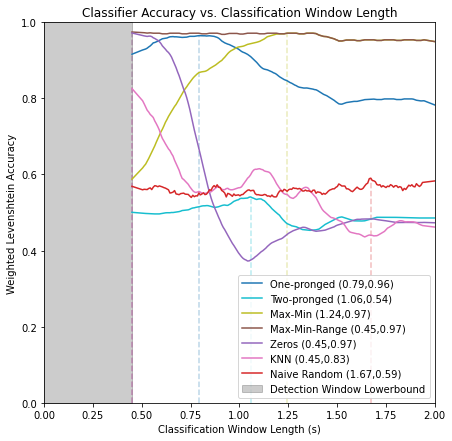

In [16]:
optimal_cl_windows = {}

plt.figure(figsize=(7, 7))
for classifier in results.classifier.unique():
    filt = results_agg.classifier == classifier
    max_arg = np.argmax(signal.savgol_filter(results_agg[filt].accuracy, 15, 1))
    max_val = np.max(signal.savgol_filter(results_agg[filt].accuracy, 15, 1))
    optimal_cl_window = np.array(results_agg[filt].window_size)[max_arg]
    optimal_cl_windows[classifier] = optimal_cl_window
    
    plt.plot(results_agg[filt].window_size, signal.savgol_filter(results_agg[filt].accuracy, 15, 1),
             label=classifier + f" ({round(optimal_cl_window, 2)},{round(max_val, 2)})", 
             color=classifier_colours[classifier])
    plt.vlines(optimal_cl_window, 0, max_val, color=classifier_colours[classifier], linestyle="--", alpha=0.3)
    
plt.ylabel("Weighted Levenshtein Accuracy")
plt.xlabel("Classification Window Length (s)")
plt.title("Classifier Accuracy vs. Classification Window Length")
plt.ylim(0, 1)
plt.xlim(0, 2)

plt.fill_between([0, opt_det_window], 0, 1, color="k", alpha = 0.2, label="Detection Window Lowerbound")


plt.legend(loc="lower right")
plt.savefig(OUT_PATH+"classifier.png")

```{figure} ../report_outputs/classifier.png
---
scale: 75%
name: classifier
---
Training accuracy of each classifier as a function of classification window length. The classification window is lower bounded by the detection window, represented by the shaded region.
Ideally, we want to minimise window length while maximising accuracy. With this in mind, we see that the Max-Min-Range classifier has the highest accuracy at a window length equal to be the lowerbound of 0.35 seconds. This makes it the most optimal classifier by both accuracy and latency.
```
<!-- reference by {numref}`classifier` -->

#### Evaluation

In [17]:
output_filename_tst_res = OUT_PATH + "test_results.csv"

if compute_all:
    open(output_filename_tst_res, 'w').close()    # Clear the file

    for classifier_label, classifier in classifiers.items():
        print(classifier_label)
        offset = (optimal_cl_windows[classifier_label] - opt_det_window)/2
        buffer_size = 0.05
        for i, key in enumerate(test_waves):
            predictions, predictions_timestamps = streaming_classifier(
                test_waves[key],
                samprate,
                classifier,
                classifier_params=classifier_parameters[classifier_label],
                input_buffer_size_sec = buffer_size,
                classification_window_size_sec = optimal_cl_windows[classifier_label],
                detection_window_size_sec = opt_det_window,
                detection_window_offset_sec = offset,
                calibration_window_size_sec = calibration_window_sec,
                calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
                event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
                event_threshold_factor = opt_thresh, 
                flip_threshold = True,
                consecutive_event_triggers = 3, 
                consecutive_nonevent_reset = 10 
            )
            actuals = "".join(test_labels[key].label)
            lev_dist = my_lev_dist(predictions, actuals)
            acc = max((len(actuals) - lev_dist), 0)/len(actuals)
            with open(output_filename_tst_res, "a") as file:
                file.write(",".join([classifier_label, key, predictions, actuals, str(lev_dist), str(acc)]) + '\n')

test_results = pd.read_csv(output_filename_tst_res, header=None)
test_results.columns = ["Classifier", "File", "Predicted", "Actual", "Weighted Levenshtein Distance", "Accuracy"]

test_results = test_results.pivot(index = "File", columns='Classifier', values='Accuracy')
test_results.loc['Total']= test_results.mean()
test_results

Classifier,KNN,Max-Min,Max-Min-Range,Naive Random,One-pronged,Two-pronged,Zeros
File,,,,,,,
data5,0.740741,0.925926,0.925926,0.611111,0.907407,0.703704,0.925926
data7,0.709677,0.870968,0.870968,0.709677,0.790323,0.701613,0.870968
Total,0.725209,0.898447,0.898447,0.660394,0.848865,0.702658,0.898447


## Summary of results

### Physics Analysis Findings: TO DO

Adapting the final experimental design after testing as the larger loop in the workflow suggests:
- Calibration instead of normalisation (explain why we did this in a senetence e.g. normalisation only scaled the egneerated signal to specific bounds, but the scale of the signal played no roll in event detection)
- Post it notes (placed beyond 45 degrees from central viewing line)
- Speed of eye movements (fast but no quantitative value)
- Electrode placement (3 cm apart at least)
- Filter

Other factors that we are aware will affect the ouput:
- blinking (didnt do anything as was not often they were detectable)
- facial movements (ensured we used a detection metric that would not classify increased noise and amplitude as an event such as zero-crossings, which just so happened to be best performing metric anyway).

...thus we ask users to play still, emphasising left and right movements.

### Data analysis finding TO DO

Results for data

## Discussion 

Initially, we used the Spike Recorder software to create and evaluate our data pipeline’s performance. But when we moved to the Python software (we had to do this because we had to integrate it with the rest of our Python code), we saw that the data was completely different. Both the threshold and shape of the signals varied between the two. This led to us re-evaluating all of the parameters of the data pipeline. We also had to perform normalisation on the new data. 

We noticed that the data obtained from the Python software had a tendency to be volatile: the random noise varied greatly at different times. To solve this issue, we calibrated our data pipeline by asking the player to keep their eyes still for 5 seconds. This allowed us to measure the amount of random noise at each particular time and hence we were able to adjust our parameters accordingly. Additionally, a few of our classifiers filter out the random noise in the data and make the waves smooth. The main cause of the random noise was, in our experience, some SpikerBoxes not working properly. So, we could reliably eliminate the volatility of the random noise by finding a SpikerBox that worked well.

Latency was a major problem in the initial stages of this project. There was a significant time delay between the eye movement and the `streaming_classifier` function being able to classify the eye movement. This was overcome by significantly reducing the window size. Additionally, when running the `streaming_classifier` function and the game in one file, we encountered significant latency. We resolved this by separating the function and the game into different files and running them at the same time. They interface through the use of inter-process communication.

Our final product for this project was a foundation model of Space Invaders. Future modifications to the game will include extra controls such as blinking or muscle movements to implement controlled shooting since we currently have smart shooting in the game which is continuous shooting unless the spaceship’s location is beneath a barrier. A multiplayer version will attract further attention as there will be an added level of competition. Another upgrade will be to include power ups such as having the ability to vary the speed of the spaceship in successive levels which will be implemented with arm muscle movements and how hard the players clenches their fist. Improvements to the actual programming aspect of the game will be to remove the use of named pipes and make it function as one application.  


## Conclusion

Physics and data science students collaborated to develop a modern twist on the classic arcade game Space Invaders, where the players now control the game with their eyes. Through data collection, developing a classifier and evaluating the classifier, we were able to create a functioning game that utilises left and right eye movements. Due to the time restrictions, we were limited in the amount of controls we were able to implement, however, we aspire to develop future upgrades to the game. These include having controlled shooting which will be executed by another control such as blinks or muscle movements, imposing a multiplayer option and power ups in the game such as varying the speed of the spaceship. Despite the challenging nature of this project, we were able to combine data science and physics expertise to develop a very successful final product.  

## Space Invaders!

## Appendix

In [18]:
def encode_msg_size(size: int) -> bytes:
    return struct.pack("<I", size)

def decode_msg_size(size_bytes: bytes) -> int:
    return struct.unpack("<I", size_bytes)[0]

def create_msg(content: bytes) -> bytes:
    size = len(content)
    return encode_msg_size(size) + content


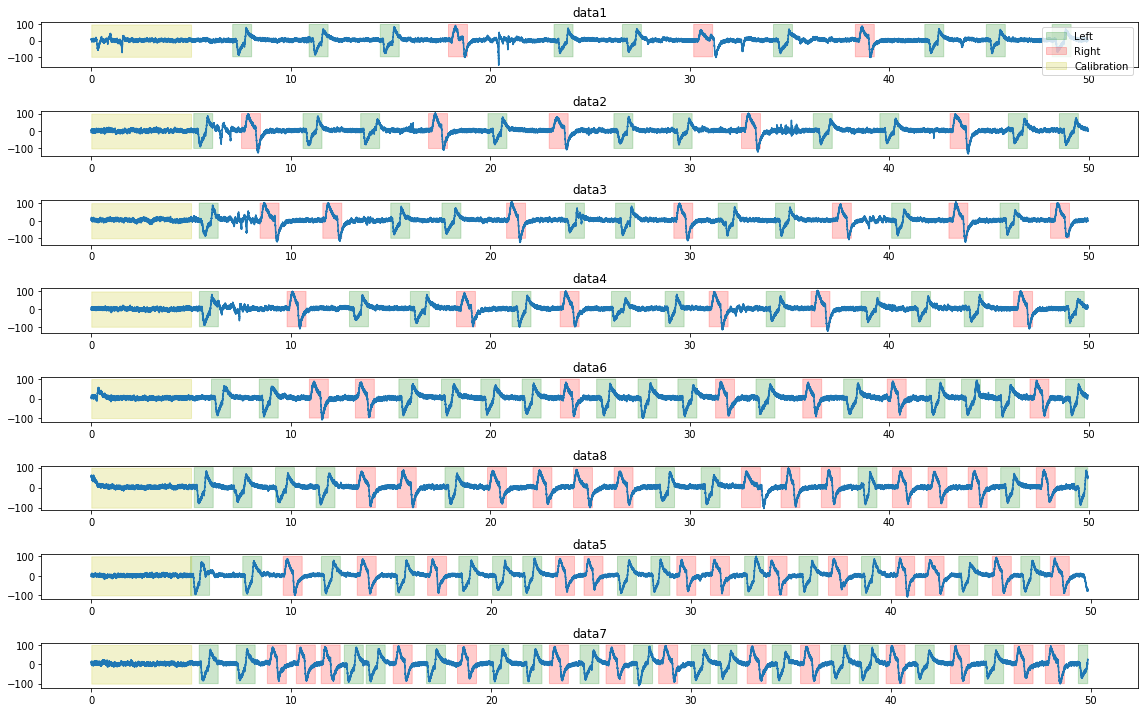

In [19]:
def plot_labelled_wave(wav_array, samprate, labels_dat, ax, i, title="", calibration_seconds = 5, 
                       before_buffer = 1, after_buffer = 1, shade_alpha=0.2, wave_alpha=1, 
                       ymin = -512, ymax = 512):
    time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate
    
    # Calibration period
    calibration_bool = time_seq < calibration_seconds

    # Get locations of events
    left_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "L"]:
        left_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | left_events_bool
    right_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "R"]:
        right_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | right_events_bool

    # Plot wave with events
    ax[i].plot(time_seq, wav_array, alpha=wave_alpha)
    ax[i].fill_between(time_seq, ymax, ymin,
                     where = left_events_bool,
                     color = 'g',
                     label = "Left",
                     alpha=shade_alpha)
    ax[i].fill_between(time_seq, ymax, ymin,
                     where = right_events_bool,
                     color = 'r',
                     label = "Right",
                     alpha=shade_alpha)
    ax[i].fill_between(time_seq, ymax, ymin,
                     where = calibration_bool,
                     color = 'y',
                     label = "Calibration",
                     alpha=shade_alpha)
    ax[i].set_title(title)
        

fig, ax = plt.subplots(8, 1)
fig.set_size_inches(16, 10)
for i, key in enumerate(sorted(waves.keys())):
    plot_labelled_wave(
        waves[key], samprate, labels[key], ax, i, title=key, before_buffer = time_buffers_whole[key][0],
        after_buffer = time_buffers_whole[key][1], shade_alpha=0.2, wave_alpha=1, ymin = -100, ymax = 100
    )
for i, key in enumerate(sorted(test_waves.keys())):
    plot_labelled_wave(
        test_waves[key], samprate, test_labels[key], ax, i+6, title=key, before_buffer = time_buffers_whole[key][0],
        after_buffer = time_buffers_whole[key][1], shade_alpha=0.2, wave_alpha=1, ymin = -100, ymax = 100
    )
ax[0].legend()
fig.tight_layout()
fig.savefig(OUT_PATH + "dataset_plot.png")


In [20]:
# Final classifier used for Space Invaders

# Connect to spiker box - change to match port
cport = "/dev/cu.usbserial-DJ00E33Q"
baudrate = 230400
ser = serial.Serial(port=cport, baudrate=baudrate)    
inputBufferSize = 1000   # 20000 = 1 second
buffer_size_sec = inputBufferSize/20000.0
ser.timeout = buffer_size_sec  # set read timeout 20000

classifier_label = "Max-Min-Range"
offset = (optimal_cl_windows[classifier_label] - opt_det_window)/2
buffer_size = 0.05
streaming_classifier(
    ser,
    samprate,
    classifiers[classifier_label],
    classifier_params=classifier_parameters[classifier_label],
    input_buffer_size_sec = buffer_size_sec,
    classification_window_size_sec = optimal_cl_windows[classifier_label],
    detection_window_size_sec = opt_det_window,
    detection_window_offset_sec = offset,
    calibration_window_size_sec = calibration_window_sec,
    calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
    event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
    event_threshold_factor = opt_thresh, 
    flip_threshold = True, 
    consecutive_event_triggers = 3, 
    consecutive_nonevent_reset = 10,
    live = True,
    FIFO_filename = "space_invaders_ipc",
    create_FIFO_msg = None,
    )


SerialException: [Errno 2] could not open port /dev/cu.usbserial-DJ00E33Q: [Errno 2] No such file or directory: '/dev/cu.usbserial-DJ00E33Q'

Below is the code used to perform feature selection on the features calculated using catch22 for the kNN classifier. An external set of data was used to determine these features as to not bias the optimisation process undertaken in 4.2.3.
This feature data was saved to `catch22_step_selected_features.csv` for use in the kNN classifier. The method undertaken to perform feature selection is described in {cite}`kaggle`.

In [ ]:
# Using backward stepwise feature selection from catch22 for kNN classifier 

# import decision tree classifier to model fitting and recursive feature exclusion (stepwise selection)

KNN_DATA_PATH = IN_PATH + "KNN/"

knn_names = ['left-middle-right-middle#2', 'left-middle-right-middle', 'left-middle-right-steph', 
            'left-middle-right-steph2', 'left-middle', 'left-right-middle-marina', 'left-right-middle-marina2', 
            'left-right-middle-marina3', 'left-right-middle-sandeep', 'right-middle']

# Load the data
knn_waves, knn_labels = load_data(
    KNN_DATA_PATH, knn_names, scale_factor = 1, shift_factor = -512, fix_alessandro=False)

# Define sample rate: 10,000 Hz
samprate = 10_000

# Extract events from training data
before_buffer = 0.5
after_buffer = 1
    
events = [] # list of events in terms of slice of wav_array
event_labels = [] # list of labels

for key in knn_labels:
    wave = knn_waves[key]
    label = knn_labels[key]
    for lab, time in zip(label.label, label.time):
        event_labels.append(lab)
        event_start = int((time - before_buffer) * samprate) # in terms of sampling rate
        event_end = int((time + after_buffer) * samprate) # in terms of sampling rate

        events.append(wave[event_start:event_end])
        
# Compute catch22 features and convert to dataframe
features = []
for event in events:
    event_ds = event[0::10] # downsample by a rate of 10
    feature = catch22_all(event_ds)
    features.append(feature['values'])

features_df = pd.DataFrame(features)
features_df.columns = feature['names']

# fit the model
clf = DecisionTreeClassifier(random_state=420)
clf.fit(features_df, event_labels)

# Python backward stepwise selection
trans = RFECV(clf, cv=5)
features_trans = trans.fit_transform(features_df, event_labels)

print(features_trans.shape)
columns_retained = features_df.iloc[:, :].columns[trans.get_support()].values
print(columns_retained)

# create df to save as csv for kNN classifier
selected_features_df = pd.DataFrame(features_trans)
selected_features_df.columns = columns_retained
selected_features_df['labels'] = event_labels

# selected_features_df.to_csv(DEP_PATH+'catch22_step_selected_features.csv',index=False)



In [ ]:
# Gridsearch to optimise consecutive_event_triggers and consecutive_nonevent_reset
# Chose minimum pair with optimal f score of 0.993 - (3, 10). A minimum pair minimises latency
if compute_all:
    trigset = {}
    for trigs in range(1, 6):
        for reset in range(5, 25):
            fscores = []
            for key in waves.keys():
                fps, fns, tps, i = 0, 0, 0, 0
                predictions, predictions_timestamps = streaming_classifier(
                    waves[key],
                    samprate,
                    lambda x,y: "R" if np.random.rand()<0.5 else "L",
                    input_buffer_size_sec = 0.05,
                    classification_window_size_sec = opt_det_window,
                    detection_window_size_sec = opt_det_window,
                    detection_window_offset_sec = 0,
                    calibration_window_size_sec = calibration_window_sec,
                    calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
                    event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
                    event_threshold_factor = 0.33, 
                    flip_threshold = True, 
                    consecutive_event_triggers = trigs, 
                    consecutive_nonevent_reset = reset
                )
                before_buffer = time_buffers_hump[key][0]
                after_buffer = time_buffers_hump[key][1]
                actual_times = [(time-before_buffer, time+after_buffer) for time in labels[key].time]
                actual_leftovers = deepcopy(actual_times)
                pred_leftovers = deepcopy(predictions_timestamps)
                tps += len(actual_times)
                for act_times in actual_times:
                    if act_times[1] < calibration_window_sec:
                        actual_leftovers.remove(act_times)
                        continue
                    for pred_times in predictions_timestamps:
                        if (act_times[0] < pred_times[1] and act_times[1] > pred_times[0] and
                            pred_times in pred_leftovers and act_times in actual_leftovers):
                            actual_leftovers.remove(act_times)
                            pred_leftovers.remove(pred_times)
                tps -= len(actual_leftovers)
                fns += len(actual_leftovers)
                fps += len(pred_leftovers)
                i += 1
                fscore = tps/(tps+0.5*(fns+fps))
                fscores.append(fscore)
            print(trigs, reset, np.mean(fscores))
            trigset[(trigs, reset)] = np.mean(fscores)


        
        

The following code performs a grid search to optimise the `rng` threshold for the Max-Min-Range classifier. The `rng` threshold is varied from 0 to 100 in increments of 1, and the corresponding weighted Levenshtein accuracies are plotted.

Max-Min-Range

Current Range Threshold: 0.0

Current Range Threshold: 1.0

Current Range Threshold: 2.0

Current Range Threshold: 3.0

Current Range Threshold: 4.0

Current Range Threshold: 5.0

Current Range Threshold: 6.0

Current Range Threshold: 7.0

Current Range Threshold: 8.0

Current Range Threshold: 9.0

Current Range Threshold: 10.0

Current Range Threshold: 11.0

Current Range Threshold: 12.0

Current Range Threshold: 13.0

Current Range Threshold: 14.0

Current Range Threshold: 15.0

Current Range Threshold: 16.0

Current Range Threshold: 17.0

Current Range Threshold: 18.0

Current Range Threshold: 19.0

Current Range Threshold: 20.0

Current Range Threshold: 21.0

Current Range Threshold: 22.0

Current Range Threshold: 23.0

Current Range Threshold: 24.0

Current Range Threshold: 25.0

Current Range Threshold: 26.0

Current Range Threshold: 27.0

Current Range Threshold: 28.0

Current Range Threshold: 29.0

Current Range Threshold: 30.0

Current Range Threshold: 31.0

Cur

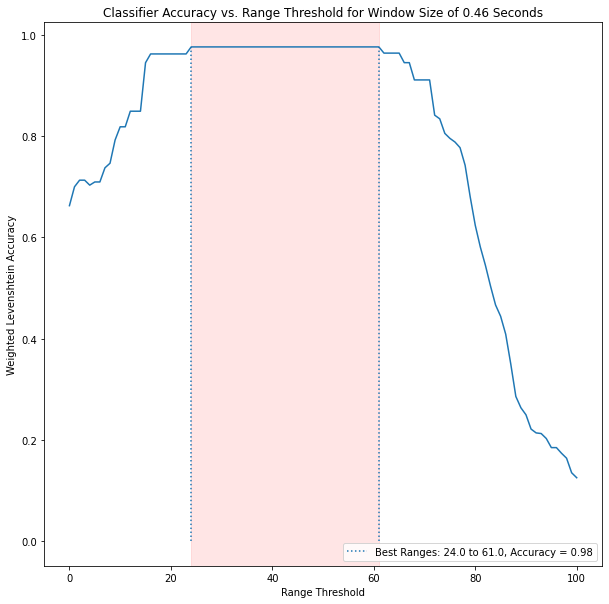

In [14]:
classifiers1 = {"Max-Min-Range": max_min_range_classifier}

file_accuracies = {}

buffer_size_sec = 0.05

if compute_all:
    for classifier_label, classifier in classifiers1.items():
        #offset = (optimal_cl_windows[classifier_label] - opt_det_window)/2
        print(classifier_label)
        for range_threshold in np.linspace(0, 100, 101):
            print("\nCurrent Range Threshold:", range_threshold)

            current_accuracies = []
            for i, key in enumerate(waves):
                
                predictions, predictions_timestamps = streaming_classifier(
                    waves[key],
                    samprate,
                    classifiers[classifier_label],
                    classifier_params={"rng" : range_threshold},
                    input_buffer_size_sec = buffer_size_sec,
                    classification_window_size_sec = 0.46,  #opt_det_window + 0.01
                    detection_window_size_sec = 0.45,       #opt_det_window
                    detection_window_offset_sec = 0.005,   #offset ^ uncomment it above
                    calibration_window_size_sec = 5,
                    calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
                    event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
                    event_threshold_factor = 0.33,          #opt_thresh 
                    flip_threshold = True, 
                    consecutive_event_triggers = 3, 
                    consecutive_nonevent_reset = 10,
                    live = False,
                )
                actuals = "".join(labels[key].label)

                lev_dist = my_lev_dist(actuals, predictions)
                acc = abs(len(actuals) - lev_dist)/len(actuals)
                current_accuracies.append(acc)
            if range_threshold in file_accuracies:
                file_accuracies[range_threshold] += current_accuracies
            else:
                file_accuracies[range_threshold] = current_accuracies


    ave_accuracies_per_range_val = {}
    for range_thresh, acc_each_file_ls in file_accuracies.items():
        ave_accuracies_per_range_val[range_thresh] = sum(acc_each_file_ls) / len(acc_each_file_ls)
    print("done")

    best_ranges = []
    best_value = 0
    for acc in ave_accuracies_per_range_val.values():
        if round(acc, 5) > round(best_value, 5):  #need to round because python maintains its floats very imprecisly
            best_value = acc

    for key, value in ave_accuracies_per_range_val.items():
        if round(value, 5) == round(best_value, 5):
            best_ranges.append(key)

    plt.figure(figsize=(10, 10))
    plt.plot(ave_accuracies_per_range_val.keys(), ave_accuracies_per_range_val.values())
    if len(best_ranges) > 1:
        plt.vlines(best_ranges[0], 0, best_value, linestyle=":", label=f"Best Ranges: {round(best_ranges[0], 2)} to {round(best_ranges[len(best_ranges) - 1], 2)}, Accuracy = {round        (best_value, 2)}")
        plt.vlines(best_ranges[len(best_ranges) - 1], 0, best_value, linestyle=":")
        plt.axvspan(best_ranges[0], best_ranges[len(best_ranges) - 1], alpha=0.1, color='red')
    else:
        plt.vlines(best_ranges[0], 0, best_value, linestyle=":", label=f"Best Range: {round(best_ranges[0], 2)}, Accuracy = {round(best_value, 2)}")

    plt.legend(loc = "lower right")
    plt.ylabel("Weighted Levenshtein Accuracy")
    plt.xlabel("Range Threshold")
    plt.title("Classifier Accuracy vs. Range Threshold for Window Size of 0.46 Seconds")

The following code performs a grid search to optimise the `consec_seconds` threshold for the Zeros classifier. The `rng` threshold is varied from 0.001 to 0.5, and the corresponding weighted Levenshtein accuracies are plotted. Note: we assume that the `consec_seconds` and `ave_height` are independent, which seems reasonable. This allows us to optimise them separately.

Zeros

Current Consec Threshold: 0.001

Current Consec Threshold: 0.0060404040404040404

Current Consec Threshold: 0.01108080808080808

Current Consec Threshold: 0.016121212121212123

Current Consec Threshold: 0.021161616161616163

Current Consec Threshold: 0.026202020202020202

Current Consec Threshold: 0.031242424242424245

Current Consec Threshold: 0.036282828282828285

Current Consec Threshold: 0.041323232323232324

Current Consec Threshold: 0.046363636363636364

Current Consec Threshold: 0.0514040404040404

Current Consec Threshold: 0.05644444444444444

Current Consec Threshold: 0.06148484848484849

Current Consec Threshold: 0.06652525252525253

Current Consec Threshold: 0.07156565656565657

Current Consec Threshold: 0.07660606060606061

Current Consec Threshold: 0.08164646464646465

Current Consec Threshold: 0.08668686868686869

Current Consec Threshold: 0.09172727272727273

Current Consec Threshold: 0.09676767676767677

Current Consec Threshold: 0.1018080808080808

Current Conse

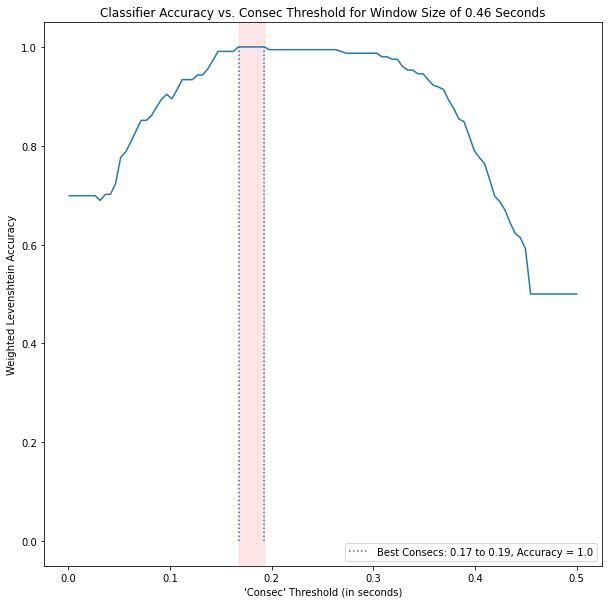

In [16]:
classifiers2 = {"Zeros": zeroes_classifier}

file_accuracies = {}

buffer_size_sec = 0.05
if compute_all:
    for classifier_label, classifier in classifiers2.items():
        print(classifier_label)
        for consec_threshold in np.linspace(0.001, 0.5, 100):
            print("\nCurrent Consec Threshold:", consec_threshold)

    #         hyp_consecutive_triggers = int(np.ceil(det_window/buffer_size))

            current_accuracies = []
            for i, key in enumerate(waves):
                
                predictions, predictions_timestamps = streaming_classifier(
                    waves[key],
                    samprate,
                    classifiers[classifier_label],
                    classifier_params={"consec_seconds": consec_threshold, "ave_height": 25},
                    input_buffer_size_sec = buffer_size_sec,
                    classification_window_size_sec = 0.46,  #opt_det_window + 0.01
                    detection_window_size_sec = 0.45,       #opt_det_window
                    detection_window_offset_sec = 0.005,   #offset
                    calibration_window_size_sec = 5,
                    calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
                    event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
                    event_threshold_factor = 0.33,          #opt_thresh 
                    flip_threshold = True, 
                    consecutive_event_triggers = 3, 
                    consecutive_nonevent_reset = 10,
                    live = False,
                )

                actuals = "".join(labels[key].label)
                lev_dist = my_lev_dist(predictions, actuals)
                acc = max((len(actuals) - lev_dist), 0)/len(actuals)
                current_accuracies.append(acc)
            if consec_threshold in file_accuracies:
                file_accuracies[consec_threshold] += current_accuracies
            else:
                file_accuracies[consec_threshold] = current_accuracies


    ave_accuracies_per_consec_val = {}
    for consec_thresh, acc_each_file_ls in file_accuracies.items():
        ave_accuracies_per_consec_val[consec_thresh] = sum(acc_each_file_ls) / len(acc_each_file_ls)

    print("done")

    best_consecs = []
    best_value = 0
    for acc in ave_accuracies_per_consec_val.values():
        if round(acc, 5) > round(best_value, 5):  #need to round because python maintains its floats very imprecisly
            best_value = acc

    for key, value in ave_accuracies_per_consec_val.items():
        if round(value, 5) == round(best_value, 5):
            best_consecs.append(key)

    plt.figure(figsize=(10, 10))
    plt.plot(ave_accuracies_per_consec_val.keys(), ave_accuracies_per_consec_val.values())
    if len(best_consecs) > 1:
        plt.vlines(best_consecs[0], 0, best_value, linestyle=":", label=f"Best Consecs: {round(best_consecs[0], 2)} to {round(best_consecs[len(best_consecs) - 1], 2)}, Accuracy = {round(best_value, 2)}")
        plt.vlines(best_consecs[len(best_consecs) - 1], 0, best_value, linestyle=":")
        plt.axvspan(best_consecs[0], best_consecs[len(best_consecs) - 1], alpha=0.1, color='red')
    else:
        plt.vlines(best_consecs[0], 0, best_value, linestyle=":", label=f"Best Consec: {round(best_consecs[0], 2)}, Accuracy = {round(best_value, 2)}")

    plt.legend(loc = "lower right")
    plt.ylabel("Weighted Levenshtein Accuracy")
    plt.xlabel("'Consec' Threshold (in seconds)")
    plt.title("Classifier Accuracy vs. Consec Threshold for Window Size of 0.46 Seconds")


The following code performs a grid search to optimise the `ave_height` threshold for the Max-Min-Range classifier. The `ave_height` threshold is varied from 0 to 6 in increments of 1, and the corresponding weighted Levenshtein accuracies are plotted. Note: we assume that the `consec_seconds` and `ave_height` are independent, which seems reasonable. This allows us to optimise them separately.

Zeros

Current Height Threshold: 0.0

Current Height Threshold: 1.0

Current Height Threshold: 2.0

Current Height Threshold: 3.0

Current Height Threshold: 4.0

Current Height Threshold: 5.0

Current Height Threshold: 6.0

Current Height Threshold: 7.0

Current Height Threshold: 8.0

Current Height Threshold: 9.0

Current Height Threshold: 10.0

Current Height Threshold: 11.0

Current Height Threshold: 12.0

Current Height Threshold: 13.0

Current Height Threshold: 14.0

Current Height Threshold: 15.0

Current Height Threshold: 16.0

Current Height Threshold: 17.0

Current Height Threshold: 18.0

Current Height Threshold: 19.0

Current Height Threshold: 20.0

Current Height Threshold: 21.0

Current Height Threshold: 22.0

Current Height Threshold: 23.0

Current Height Threshold: 24.0

Current Height Threshold: 25.0

Current Height Threshold: 26.0

Current Height Threshold: 27.0

Current Height Threshold: 28.0

Current Height Threshold: 29.0

Current Height Threshold: 30.0

Current Hei

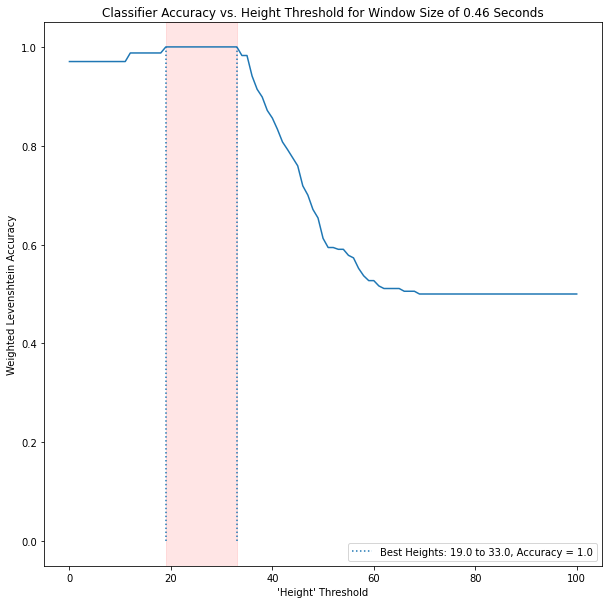

In [17]:
classifiers2 = {"Zeros": zeroes_classifier}

file_accuracies = {}

buffer_size_sec = 0.05
if compute_all:
    for classifier_label, classifier in classifiers2.items():
        print(classifier_label)
        for height_threshold in np.linspace(0, 100, 101):                                
            print("\nCurrent Height Threshold:", height_threshold)

    #         hyp_consecutive_triggers = int(np.ceil(det_window/buffer_size))

            current_accuracies = []
            for i, key in enumerate(waves):
                
                predictions, predictions_timestamps = streaming_classifier(
                    waves[key],
                    samprate,
                    classifiers[classifier_label],
                    classifier_params={"consec_seconds": 0.18, "ave_height": height_threshold},
                    input_buffer_size_sec = buffer_size_sec,
                    classification_window_size_sec = 0.46,   #opt_det_window + 0.01
                    detection_window_size_sec = 0.45,        #opt_det_window
                    detection_window_offset_sec = 0.005,   #offset
                    calibration_window_size_sec = 5,
                    calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
                    event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
                    event_threshold_factor = 0.33,          #opt_thresh 
                    flip_threshold = True, 
                    consecutive_event_triggers = 3, 
                    consecutive_nonevent_reset = 10,
                    live = False,
                )

                actuals = "".join(labels[key].label)
                lev_dist = my_lev_dist(predictions, actuals)
                acc = max((len(actuals) - lev_dist), 0)/len(actuals)
                current_accuracies.append(acc)
            if height_threshold in file_accuracies:
                file_accuracies[height_threshold] += current_accuracies
            else:
                file_accuracies[height_threshold] = current_accuracies


    ave_accuracies_per_height_val = {}
    for height_thresh, acc_each_file_ls in file_accuracies.items():
        ave_accuracies_per_height_val[height_thresh] = sum(acc_each_file_ls) / len(acc_each_file_ls)

    print("done")

    best_heights = []
    best_value = 0
    for acc in ave_accuracies_per_height_val.values():
        if round(acc, 5) > round(best_value, 5):  #need to round because python maintains its floats very imprecisly
            best_value = acc

    for key, value in ave_accuracies_per_height_val.items():
        if round(value, 5) == round(best_value, 5):
            best_heights.append(key)

    plt.figure(figsize=(10, 10))
    plt.plot(ave_accuracies_per_height_val.keys(), ave_accuracies_per_height_val.values())
    if len(best_heights) > 1:
        plt.vlines(best_heights[0], 0, best_value, linestyle=":", label=f"Best Heights: {round(best_heights[0], 2)} to {round(best_heights[len(best_heights) - 1], 2)}, Accuracy = {round(best_value, 2)}")
        plt.vlines(best_heights[len(best_heights) - 1], 0, best_value, linestyle=":")
        plt.axvspan(best_heights[0], best_heights[len(best_heights) - 1], alpha=0.1, color='red')
    else:
        plt.vlines(best_heights[0], 0, best_value, linestyle=":", label=f"Best Height: {round(best_heights[0], 2)}, Accuracy = {round(best_value, 2)}")


    plt.legend(loc = "lower right")
    plt.ylabel("Weighted Levenshtein Accuracy")
    plt.xlabel("'Height' Threshold")
    plt.title("Classifier Accuracy vs. Height Threshold for Window Size of 0.46 Seconds")


## References 

{cite}`numpy`
{cite}`pandas`
{cite}`scipy`
{cite}`plot`
{cite}`catch22`
{cite}`sklearn`
{cite}`numba`
{cite}`levdist`
{cite}`serial`

```{bibliography}
```

http://blog.juliusschulz.de/blog/ultimate-ipython-notebook